In [1]:
import requests
import json

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

In [2]:
url = "https://gateway.apiportal.ns.nl/nsapp-stations/v3"
params = {
    "includeNonPlannableStations": "false",
    "countryCodes": "NL"  # Use the correct format for the API
}

headers = {
    'Cache-Control': 'no-cache',
    'Ocp-Apim-Subscription-Key': 'f2c5d3b7254549e58dd163d4439b8cff',
}
reload = False

if reload:
    try:
        response = requests.get(url, headers=headers, params=params)
        response.raise_for_status()  # Raises an HTTPError if the HTTP request returned an unsuccessful status code
        
        response_dict = response.json()  # Parse the JSON response to a dictionary
        print(response.status_code)
        print(json.dumps(response_dict, indent=2))  # Pretty print the JSON response
    
    except requests.exceptions.HTTPError as http_err:
        print(f'HTTP error occurred: {http_err}')
        response_dict = None
    except Exception as err:
        print(f'Other error occurred: {err}')
        response_dict = None

    # Filter entries where country is "NL"
    filtered_payload = [entry for entry in response_dict['payload'] if entry['country'] == 'NL']
    
    # Create a DataFrame from the filtered data
    df = pd.DataFrame(filtered_payload)
    
    # Create a GeoDataFrame
    geometry = [Point(entry['location']['lng'], entry['location']['lat']) for entry in filtered_payload]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    # Convert to EPSG:3857
    gdf = gdf.to_crs('EPSG:3857')
    
    # Save the GeoDataFrame as pickle file
    gdf.to_pickle('ns_stations.pkl')
else:
    # Open the pickle
    gdf = pd.read_pickle('ns_stations.pkl')

# Print the GeoDataFrame
gdf.head()

,id,stationType,names,location,tracks,hasKnownFacilities,availableForAccessibleTravel,hasTravelAssistance,areTracksIndependentlyAccessible,isBorderStop,country,radius,approachingRadius,startDate,nearbyMeLocationId,geometry
0,"{'uicCode': '8400045', 'evaCode': '8400045', '...",LOCAL_TRAIN_STATION,"{'long': 'Aalten', 'medium': 'Aalten', 'short'...","{'lat': 51.9213265245505, 'lng': 6.57862722873...","[1, 2]",True,True,True,True,False,NL,200,1200,2020-05-13,"{'value': 'ATN', 'type': 'stationV3'}",POINT (732329.433 6785912.762)
1,"{'uicCode': '8400047', 'evaCode': '8400047', '...",LOCAL_TRAIN_STATION,"{'long': 'Abcoude', 'medium': 'Abcoude', 'shor...","{'lat': 52.2785, 'lng': 4.977}","[2, 3]",True,True,True,True,False,NL,200,1200,2011-05-01,"{'value': 'AC', 'type': 'stationV3'}",POINT (554037.106 6850639.324)
2,"{'uicCode': '8400049', 'evaCode': '8400049', '...",LOCAL_TRAIN_STATION,"{'long': 'Akkrum', 'medium': 'Akkrum', 'short'...","{'lat': 53.0463905334473, 'lng': 5.84361124038...","[2, 3]",True,True,True,False,False,NL,200,1600,2023-12-10,"{'value': 'AKM', 'type': 'stationV3'}",POINT (650507.828 6991583.528)
3,"{'uicCode': '8400050', 'evaCode': '8400050', '...",INTERCITY_HUB_STATION,"{'long': 'Alkmaar', 'medium': 'Alkmaar', 'shor...","{'lat': 52.6377792358398, 'lng': 4.73972225189...","[1, 2, 3, 4, 5]",True,True,True,True,False,NL,525,1200,2003-07-01,"{'value': 'AMR', 'type': 'stationV3'}",POINT (527623.468 6916275.932)
4,"{'uicCode': '8400051', 'evaCode': '8400051', '...",INTERCITY_HUB_STATION,"{'long': 'Almelo', 'medium': 'Almelo', 'short'...","{'lat': 52.3580551147461, 'lng': 6.65388870239...","[2, 2a, 2b, 3b, 4, 4a, 4b]",True,True,True,True,False,NL,525,1200,2023-12-10,"{'value': 'AML', 'type': 'stationV3'}",POINT (740707.502 6865127.147)


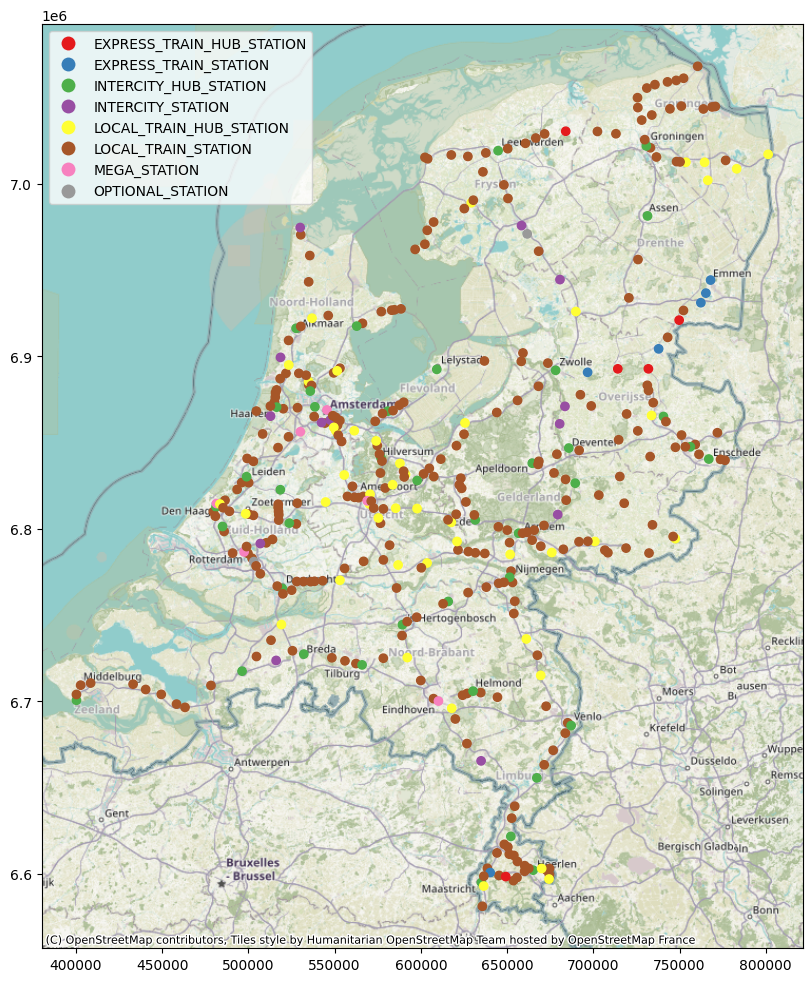

In [3]:
# Add a background map with contextily
import contextily as ctx
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 12))
gdf.plot(ax=ax, column='stationType', legend=True, cmap='Set1')
ctx.add_basemap(ax)
plt.show()

In [4]:
# Print the count of the stationTypes
gdf['stationType'].value_counts()

stationType
LOCAL_TRAIN_STATION          279
LOCAL_TRAIN_HUB_STATION       46
INTERCITY_HUB_STATION         40
INTERCITY_STATION             13
MEGA_STATION                   6
EXPRESS_TRAIN_STATION          6
EXPRESS_TRAIN_HUB_STATION      5
OPTIONAL_STATION               2
Name: count, dtype: int64

### Filter the data to the specific region

In [5]:
# Load ../v_mrdh/areas_65.pkl as geodataframe
areas65 = pd.read_pickle('../v_mrdh/areas_65.pkl')
areas65.head()

,geometry,65x65 Naam,GEBIEDEN,WONINGEN_A,INWONERS_A,ARBEIDSPL_,LLP12EO_AR,LLP0011_AR,PARKEER_TA,AUTOSPERHH,...,1: woningen,2: inwoners,3: inwon0034,4: bbv,5: llp12eo,6: detail,7: industrie,8: rest,9: arbeidspl_totaal,10: gebiedstype
65x65 Nummer,,,,,,,,,,,,,,,,,,,,,
1,"MULTIPOLYGON (((91572.39 435285.08, 91571.6 43...",Rotterdam Centrum,studiegebied RVMK,21529,36209,88158,37649,2213,4.14,0.495,...,21529,36209,18948,16284,37649,9151,7019,71988,88158,1
2,"POLYGON ((89429 435269.999, 89384 435277.999, ...",Delfshaven,studiegebied RVMK,39740,77508,17468,9165,6332,1.76,0.460,...,39740,77508,41160,30429,9165,3430,1068,12970,17468,1
3,"POLYGON ((89677.053 437491.512, 89672.17 43749...",Noord,studiegebied RVMK,29516,52490,12453,10649,2807,1.76,0.425,...,29516,52490,27808,23956,10649,3235,499,8719,12453,1
4,"POLYGON ((93801.859 437558.61, 93800.797 43756...",Kralingen,studiegebied RVMK,30714,53939,25025,36520,4257,1.76,0.480,...,30714,53939,28785,19379,36520,2758,4634,17633,25025,1
5,"POLYGON ((94944.584 431561.346, 94944.374 4315...",IJsselmonde (bi),studiegebied RVMK,22324,45467,16658,4404,3906,0.00,0.650,...,22324,45467,19990,16927,4404,2587,1931,12140,16658,1


['studiegebied RVMK' 'studiegebied VMH' 'Invloedsgebied'
 'Invloedsgebied verfijnd vmh' 'Invloedsgebied verfijnd'
 'Buitengebied obv LMS' 'Buitengebied obv COROP']


<Axes: >

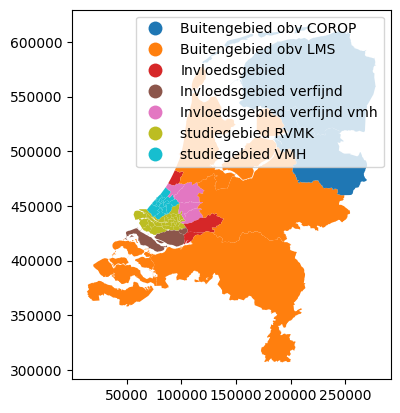

In [6]:
# Print the unique values of the GEBIEDEN column
print(areas65['GEBIEDEN'].unique())
areas65.plot(column='GEBIEDEN', legend=True)

In [7]:
buitengebieden = ['Buitengebied obv LMS', 'Buitengebied obv COROP']

buitengebied = areas65[areas65['GEBIEDEN'].isin(buitengebieden)].dissolve()
urban = areas65[~areas65['GEBIEDEN'].isin(buitengebieden)].dissolve()

<Axes: >

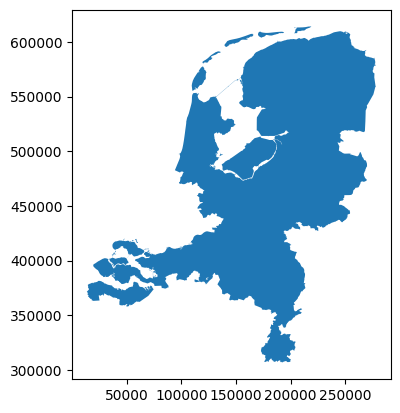

In [8]:
buitengebied.plot()

In [9]:
# Select all the stations in the urban area
urban_stations = gpd.sjoin(gdf.to_crs(epsg=28992), urban, predicate='within')

# Select all the INTERCITY_HUB_STATION and INTERCITY_STATION and MEGA_STATION
buitengebied_stations = gdf[(gdf['stationType'] == 'INTERCITY_HUB_STATION') | (gdf['stationType'] == 'INTERCITY_STATION') | (gdf['stationType'] == 'MEGA_STATION')]
buitengebied_stations = gpd.sjoin(buitengebied_stations.to_crs(epsg=28992), buitengebied, predicate='within')

In [10]:
# Save the GeoDataFrames as pickle files
urban_stations.to_pickle('urban_stations.pkl')
buitengebied_stations.to_pickle('buitengebied_stations.pkl')